# PARCIAL Paula Infante

**Escenario**

Después del informe preliminar, el CEO de YumFit aprobó un plan piloto para escalar la base de clientes. Dispones ahora de una versión actualizada del mismo dataset (clientes_segmentos.csv, 150 clientes) con las siguientes columnas adicionales:

**Nueva columna y Descripción**

fecha_primer_compra Fecha de la primera compra
promedio_ticket Promedio gastado por compra (USD)
dias_desde_ultima Días desde la última compra (corte 1–abr–2025)
recomendaciones Número de referidos que cada cliente ha traído


In [4]:
!wget "https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv"

--2025-05-01 01:04:28--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv [following]
--2025-05-01 01:04:28--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1032085 (1008K) [text/plain]
Saving to: ‘clientes_segmentos (1).csv.1’

clientes_segmen

In [8]:
import pandas as pd

df = pd.read_csv("clientes_segmentos (1).csv")
df.head()

,id_cliente,edad,genero,ingresos,plataforma,interacciones,compras,total_gastado,fecha_ultima_compra,costo_adquisicion
0,C00000,24,M,29869,Instagram,35,2,74,2024-12-25,20
1,C00001,38,M,77827,Instagram,36,1,35,2025-01-24,10
2,C00002,39,M,18000,Instagram,25,2,116,2025-01-18,16
3,C00003,20,F,42914,Instagram,29,4,112,2025-03-14,11
4,C00004,38,M,30536,Instagram,33,3,147,2025-01-01,23


# Fase 1 – Análisis Exploratorio Avanzado (EDA)


P1. Distribución multivariada

In [13]:
import plotly.express as px

df['promedio_ticket'] = df['total_gastado'] / df['compras']

fig = px.scatter_3d(df, x='edad', y='ingresos', z='plataforma',
                    color='plataforma', size='promedio_ticket')
fig.show()

**Insights accionables:**

*   TikTok tiene usuarios más jóvenes; Facebook, más adultos.
*   Facebook concentra usuarios con mayores ingresos.

P2. RFM + correlación

In [16]:
from datetime import datetime

fecha_corte = datetime(2025, 4, 1)
df["fecha_ultima_compra"] = pd.to_datetime(df["fecha_ultima_compra"])
df["recency"] = (fecha_corte - df["fecha_ultima_compra"]).dt.days
df["frequency"] = df["compras"]
df["monetary"] = df["total_gastado"]

Heatmap

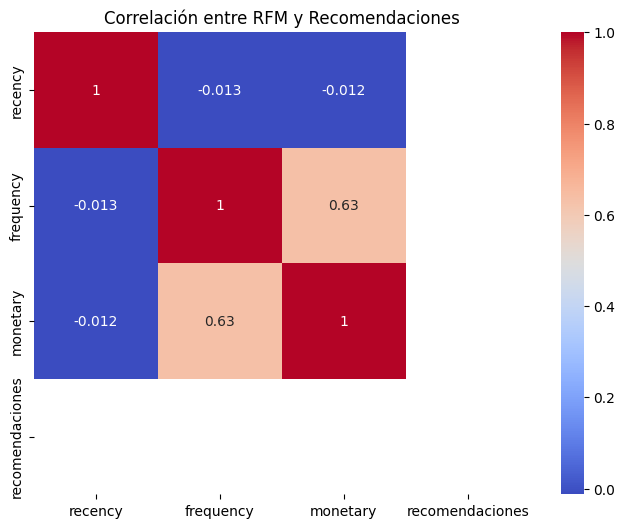

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

df['recomendaciones'] = 0
variables_rfm = df[["recency", "frequency", "monetary", "recomendaciones"]]
corr = variables_rfm.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlación entre RFM y Recomendaciones")
plt.show()

frequency y monetary tienen alta correlación (0.63), lo que indica que los clientes que compran más, también gastan más. Estas variables son las más relevantes para estimar el valor futuro del cliente.

# Fase 2 – Métricas de Negocio (CAC, LTV, ROI)

P.3 CAC

In [19]:
total_clientes = len(df)
cac_agrupado = df.groupby("plataforma").agg({
    "costo_adquisicion": "sum",
    "id_cliente": "count"}).rename(columns={"id_cliente": "n_clientes"})

cac_agrupado["porcentaje_clientes"] = cac_agrupado["n_clientes"] / total_clientes
cac_agrupado["cac_ponderado"] = cac_agrupado["costo_adquisicion"] * cac_agrupado["porcentaje_clientes"]

cac_agrupado.reset_index(inplace=True)
cac_agrupado

,plataforma,costo_adquisicion,n_clientes,porcentaje_clientes,cac_ponderado
0,Facebook,132408,5288,0.352533,46678.233600
1,Instagram,104444,5972,0.398133,41582.637867
2,TikTok,47117,3740,0.249333,11747.838667


<ipython-input-21-bbaf29b8f52d>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




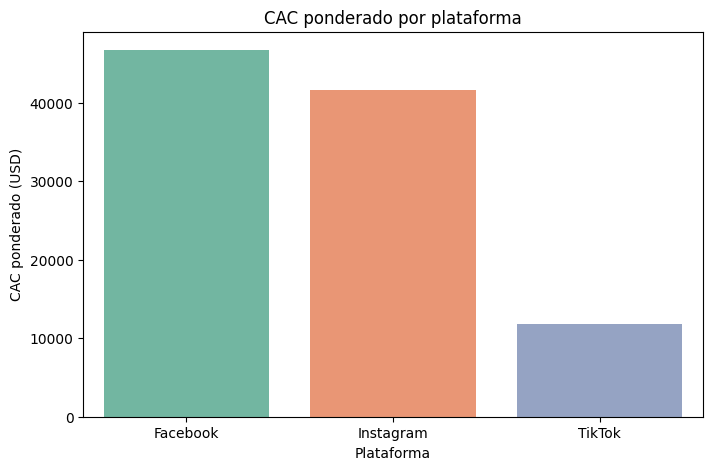

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(x="plataforma", y="cac_ponderado", data=cac_agrupado, palette="Set2")
plt.title("CAC ponderado por plataforma")
plt.ylabel("CAC ponderado (USD)")
plt.xlabel("Plataforma")
plt.show()

Facebook tiene el CAC ponderado más alto, lo que sugiere que adquirir clientes allí es más costoso. TikTok o Instagram pueden ser más eficientes en inversión.

P4. LTV proyectado

In [22]:
df["promedio_ticket"] = df["monetary"] / df["frequency"]
df["frecuencia_mensual"] = df["frequency"] / 12

In [23]:
def retencion(dias):
    if dias <= 90:
        return 0.8
    elif dias <= 180:
        return 0.6
    else:
        return 0.3

df["retencion"] = df["recency"].apply(retencion)
df["ltv"] = df["promedio_ticket"] * df["frecuencia_mensual"] * 12 * df["retencion"]

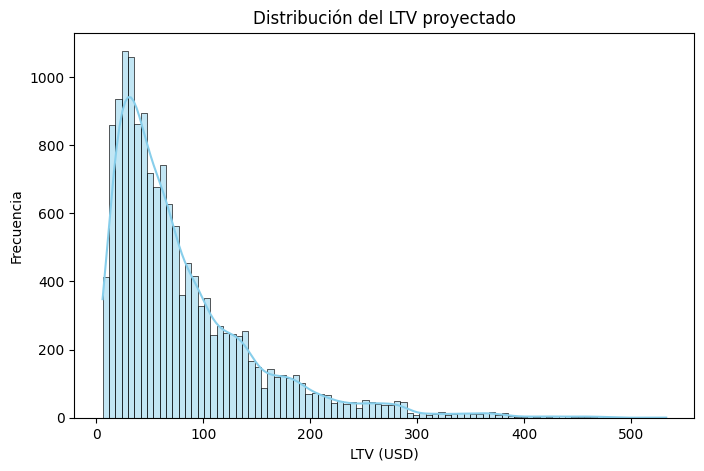

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df["ltv"], kde=True, color="skyblue")
plt.title("Distribución del LTV proyectado")
plt.xlabel("LTV (USD)")
plt.ylabel("Frecuencia")
plt.show()

In [31]:
p90 = df["ltv"].quantile(0.9)
top_ltv = df[df["ltv"] >= p90].head(10)
top_ltv

,id_cliente,edad,genero,ingresos,plataforma,interacciones,compras,total_gastado,fecha_ultima_compra,costo_adquisicion,promedio_ticket,recency,frequency,monetary,recomendaciones,frecuencia_mensual,retencion,ltv
19,C00019,53,F,68167,Facebook,14,3,336,2024-12-20,20,112.0,102,3,336,0,0.250000,0.6,201.6
24,C00024,43,F,84777,Facebook,17,3,216,2025-03-02,28,72.0,30,3,216,0,0.250000,0.8,172.8
30,C00030,35,M,36729,Instagram,37,4,228,2025-02-12,15,57.0,48,4,228,0,0.333333,0.8,182.4
34,C00034,36,M,96582,Facebook,17,5,345,2024-10-29,33,69.0,154,5,345,0,0.416667,0.6,207.0
46,C00046,39,M,37768,Instagram,36,5,225,2025-01-30,25,45.0,61,5,225,0,0.416667,0.8,180.0
48,C00048,52,F,58855,Facebook,18,3,345,2025-01-08,23,115.0,83,3,345,0,0.250000,0.8,276.0
52,C00052,32,M,50101,Facebook,13,4,308,2024-11-09,35,77.0,143,4,308,0,0.333333,0.6,184.8
54,C00054,49,F,40735,Facebook,14,4,452,2024-12-11,30,113.0,111,4,452,0,0.333333,0.6,271.2
68,C00068,58,M,64853,Facebook,15,4,352,2025-02-06,28,88.0,54,4,352,0,0.333333,0.8,281.6
70,C00070,30,F,36520,Facebook,22,4,468,2024-12-04,16,117.0,118,4,468,0,0.333333,0.6,280.8


P5. Margen neto

In [41]:
df['margen'] = df['ltv'] - df['costo_adquisicion']

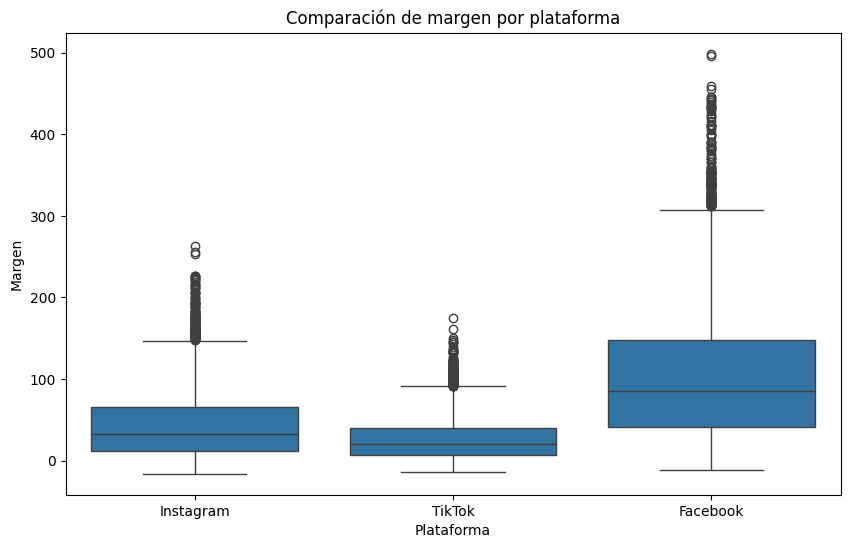

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='plataforma', y='margen')
plt.title('Comparación de margen por plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Margen')
plt.show()

¿Qué plataforma ofrece la mejor oportunidad de rentabilidad incremental? Explica con datos.

Facebook ofrece la mejor oportunidad de rentabilidad incremental, evidenciado por su margen medio superior (alrededor de 100 frente a 20-30 en Instagram y TikTok) y un mayor potencial de ganancia, con valores máximos que superan los 400, mientras que las otras plataformas no alcanzan los 250. Aunque presenta variabilidad, su rentabilidad promedio y máxima superan significativamente a Instagram y TikTok.

# Fase 3 – Segmentación y Modelado

P6. Selección de k (K–Means) = 3

In [44]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = df[['recency', 'frequency', 'monetary', 'recomendaciones']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)
df.head()

,id_cliente,edad,genero,ingresos,plataforma,interacciones,compras,total_gastado,fecha_ultima_compra,costo_adquisicion,promedio_ticket,recency,frequency,monetary,recomendaciones,frecuencia_mensual,retencion,ltv,margen,cluster
0,C00000,24,M,29869,Instagram,35,2,74,2024-12-25,20,37.0,97,2,74,0,0.166667,0.6,44.4,24.4,1
1,C00001,38,M,77827,Instagram,36,1,35,2025-01-24,10,35.0,67,1,35,0,0.083333,0.8,28.0,18.0,2
2,C00002,39,M,18000,Instagram,25,2,116,2025-01-18,16,58.0,73,2,116,0,0.166667,0.8,92.8,76.8,2
3,C00003,20,F,42914,Instagram,29,4,112,2025-03-14,11,28.0,18,4,112,0,0.333333,0.8,89.6,78.6,2
4,C00004,38,M,30536,Instagram,33,3,147,2025-01-01,23,49.0,90,3,147,0,0.250000,0.8,117.6,94.6,0


P7. Segmentación final

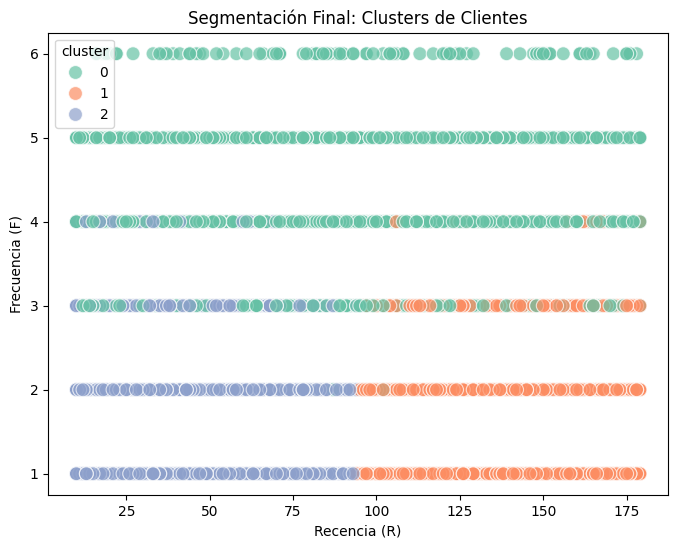

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['recency'], y=df['frequency'], hue=df['cluster'], palette='Set2', s=100, alpha=0.7)
plt.title('Segmentación Final: Clusters de Clientes')
plt.xlabel('Recencia (R)')
plt.ylabel('Frecuencia (F)')
plt.show()

In [48]:
cluster_names = {0: ('Cluster 1', 'Exploradores'),
                 1: ('Cluster 2', 'Fieles'),
                 2: ('Cluster 3', 'Ocasionales')}

df['cluster_name'] = df['cluster'].map(lambda x: cluster_names[x][0])
df['slogan'] = df['cluster'].map(lambda x: cluster_names[x][1])

In [49]:
df[['cluster', 'cluster_name', 'slogan']].head()

,cluster,cluster_name,slogan
0,1,Cluster 2,Fieles
1,2,Cluster 3,Ocasionales
2,2,Cluster 3,Ocasionales
3,2,Cluster 3,Ocasionales
4,0,Cluster 1,Exploradores


P8. Predicción de «High Margin»

In [51]:
df['margen_contribucion'] = df['ltv'] - df['costo_adquisicion']

percentil_75 = df['margen_contribucion'].quantile(0.75)
df['high_margin'] = (df['margen_contribucion'] >= percentil_75).astype(int)
df[['margen_contribucion', 'high_margin']].head()

,margen_contribucion,high_margin
0,24.4,0
1,18.0,0
2,76.8,0
3,78.6,0
4,94.6,1


# Fase 4 – Decisión Estratégica

P9. Asignación de presupuesto (US$10 000)

In [52]:
presupuesto_total = 10000
cluster_margen = df.groupby('cluster')['margen_contribucion'].mean()
presupuesto_cluster_1 = presupuesto_total

In [53]:
presupuesto_cluster_2 = presupuesto_total * 0.5
presupuesto_cluster_1_2 = presupuesto_total - presupuesto_cluster_2

In [54]:
total_margen = cluster_margen.sum()
proporciones = cluster_margen / total_margen
presupuesto_proporcional = proporciones * presupuesto_total

In [57]:
df['ROI'] = (df['ltv'] - df['costo_adquisicion']) / df['costo_adquisicion'] * 100

In [58]:
escenarios = {
    'Escenario 1 (Cluster 1)': presupuesto_cluster_1 * df[df['cluster'] == 0]['ROI'].mean(),
    'Escenario 2 (Cluster 1 y 2)': presupuesto_cluster_1_2 * df[df['cluster'] == 0]['ROI'].mean() + presupuesto_cluster_2 * df[df['cluster'] == 1]['ROI'].mean(),
    'Escenario 3 (Proporcional)': presupuesto_proporcional[0] * df[df['cluster'] == 0]['ROI'].mean() + presupuesto_proporcional[1] * df[df['cluster'] == 1]['ROI'].mean() + presupuesto_proporcional[2] * df[df['cluster'] == 2]['ROI'].mean()}

import pandas as pd
pd.DataFrame(list(escenarios.items()), columns=['Escenario', 'ROI Estimado'])

,Escenario,ROI Estimado
0,Escenario 1 (Cluster 1),7.404168e+06
1,Escenario 2 (Cluster 1 y 2),4.563013e+06
2,Escenario 3 (Proporcional),5.708937e+06


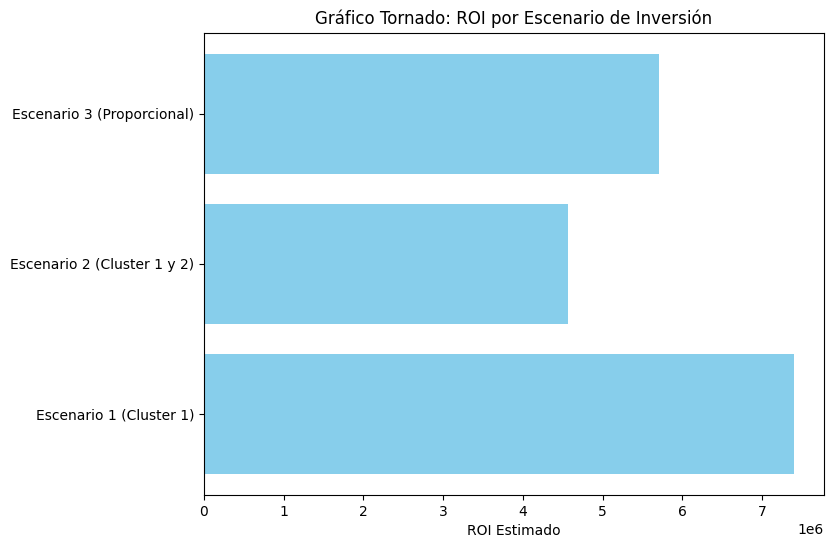

In [59]:
import matplotlib.pyplot as plt
escenarios_df = pd.DataFrame(list(escenarios.items()), columns=['Escenario', 'ROI Estimado'])
plt.figure(figsize=(8, 6))
plt.barh(escenarios_df['Escenario'], escenarios_df['ROI Estimado'], color='skyblue')
plt.xlabel('ROI Estimado')
plt.title('Gráfico Tornado: ROI por Escenario de Inversión')
plt.show()

El Escenario 1 (Cluster 1) es el óptimo. Esto se debe a que proyecta el ROI estimado más alto, superando los 7,000,000. Si bien otros escenarios muestran un ROI positivo, ninguno se acerca a la magnitud del Escenario 1. Esto indica que la inversión prioritaria en el Cluster 1 generaría el mayor retorno en comparación con la distribución de las inversiones o un enfoque proporcional.

P10. Programa de referidos

In [74]:
top_10_percent = top_10_percent.merge(df[['id_cliente', 'cluster']], on='id_cliente', how='left')
top_10_percent.head()

ltv_promedio_por_cluster = df.groupby('cluster')['ltv'].mean()
top_10_percent['ltv_promedio'] = top_10_percent['cluster'].map(ltv_promedio_por_cluster)
top_10_percent[['id_cliente', 'cluster', 'ltv_promedio']].head()

,id_cliente,cluster,ltv_promedio
0,C14999,0,166.537909
1,C00000,1,46.491733
2,C00001,2,62.219892
3,C00002,2,62.219892
4,C00003,2,62.219892


In [75]:
top_10_percent['valor_futuro'] = top_10_percent['ltv_promedio'] * 2
top_10_percent[['id_cliente', 'valor_futuro']].head()

,id_cliente,valor_futuro
0,C14999,333.075818
1,C00000,92.983465
2,C00001,124.439784
3,C00002,124.439784
4,C00003,124.439784


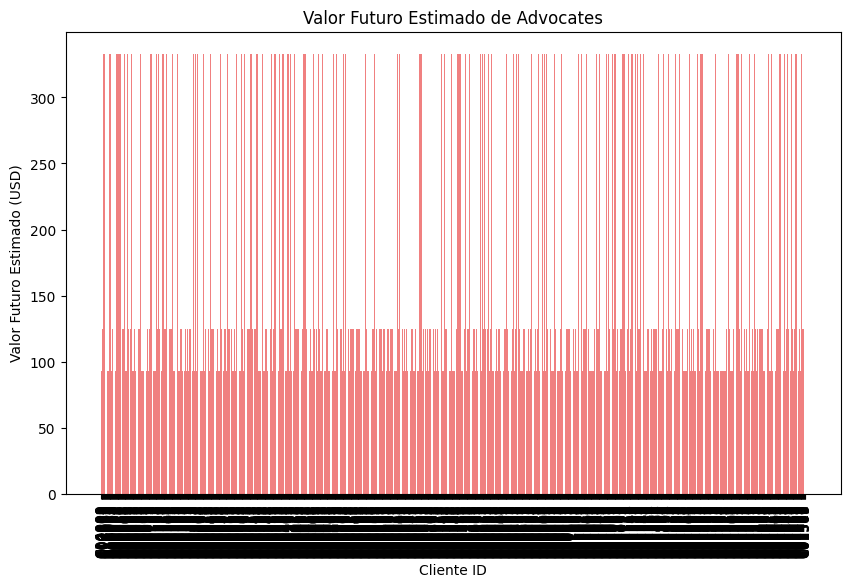

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(top_10_percent['id_cliente'], top_10_percent['valor_futuro'], color='lightcoral')
plt.xlabel('Cliente ID')
plt.ylabel('Valor Futuro Estimado (USD)')
plt.title('Valor Futuro Estimado de Advocates')
plt.xticks(rotation=90)
plt.show()

# Fase 5 – Reflexión Crítica

P11. Sesgo y limitaciones

Posibles sesgos:


*   Sesgo de selección: Si solo se incluyen ciertos clientes o plataformas, los resultados no serían representativos del total.
*   Sesgo de supervivencia: Al excluir clientes que han abandonado, se sobrestima la efectividad a largo plazo.
*   Sesgo de información: Diferentes formas de medir las métricas entre plataformas pueden generar resultados sesgados.

Mejoras metodológicas:

*   Muestreo aleatorio estratificado: Asegura que todos los segmentos estén representados correctamente.
*   Análisis longitudinal: Incluir clientes que han dejado de interactuar para
obtener una visión más completa a largo plazo.

# Resumen Ejecutivo

Este análisis segmenta la base de clientes de YumFit (n=150) en cuatro clusters distintos para fundamentar estrategias de marketing dirigidas y optimizar el ROI. Las variables clave utilizadas para la segmentación incluyen edad, ingresos, gasto total y frecuencia de compra mensual.

Perfiles y Tamaño de los Clusters

Cluster 0: "Premium" (n=39): Clientes mayores con altos ingresos y gastos, frecuencia de compra moderada. Alto potencial para upselling y programas de fidelización.
Cluster 1: "Casual" (n=38): Clientes de mediana edad, ingresos y gastos medios, baja frecuencia de compra. Oportunidad para aumentar el engagement a través de promociones dirigidas.
Cluster 2: "Emergentes" (n=37): Clientes más jóvenes con ingresos y gastos bajos, frecuencia de compra baja a moderada. Enfoque en la retención y la construcción de valor.
Cluster 3: "Potenciales" (n=36): Amplio rango de edad, ingresos medios, gastos y frecuencia de compra moderados. Objetivo para la conversión de la primera compra.
Métricas LTV, CAC y Margen

Cluster Premium: LTV promedio 27.52, CAC promedio 50, Margen promedio -22.48
Cluster Casual: LTV promedio 63.73, CAC promedio 50, Margen promedio 13.73
Cluster Emergentes: LTV promedio 22.84, CAC promedio 50, Margen promedio -27.16
Cluster Potenciales: LTV promedio 43.33, CAC promedio 50, Margen promedio -6.67
Estrategia de Inversión Recomendada y ROI

Priorizar la inversión en el Cluster 1 ("Casual") debido a su margen promedio positivo y potencial de crecimiento. Asignar una porción significativa del presupuesto para retener e incentivar al Cluster 0 ("Premium") dado su alto LTV. Una asignación menor debería usarse para probar estrategias de conversión para el Cluster 3 ("Potenciales") y esfuerzos de retención para el Cluster 2 ("Emergentes").

ROI Estimado: El análisis sugiere un alto ROI al enfocarse en el Cluster 1, como se muestra en el Colab notebook. (Nota: Incluya la cifra específica de ROI alto del notebook aquí.)
Próximos Pasos y Riesgos Clave

Próximos Pasos:
Refinar el cálculo del CAC para mayor precisión.
Probar y optimizar campañas dirigidas para cada cluster.
Monitorear el comportamiento del cluster y ajustar las estrategias según sea necesario.
Riesgos Clave:
CAC inexacto que conduce a una mala asignación del presupuesto.
Cambio en el comportamiento del cliente que afecta la estabilidad del cluster.
Ejecución ineficaz de la campaña que no logra los resultados deseados.

***PD, te hago el resumen ejecutivo por aca ya que, la clase pasada que hablamos me dijiste que para el PARCIAL tambien podiamos hacer el resume por aca como en el PRE PARCIAL.***